# Proefening 2

In deze tweede oefening gaan we een complexere analyse doen, door te kijken welke punten overlappen met een deel van de BGT vlakken.
Run hiervoor eerst het notebook download_bgt.ipynb. Hier kan je eerst de beschikbare collecties van de BGT printen, en vervolgens een deel van de BGT downloaden.
Deze wordt automatisch in je output folder opgeslagen.

het script maakt gebruik van de bounding box uit de env.yml file. De bounding box is in het format [minx, miny, maxx, maxx]. Uit je AHN5 file kan je de minimale waardes al halen. Tel hier 1000 bij op (want het is 1km bij 1km) voor de max waardes. Pas deze waarde voor nu niet aan, omdat die overeenkomt met je data.

In de env.yml staan deze al goed, als je geen eigen .las file hebt gekozen!

De output wordt opgeslagen in je output folder, als bgt_collections.gpkg.

### Package imports

In [2]:
import laspy as lp
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import os
import yaml
import logging
from typing import Optional
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from shapely.geometry import Point
from shapely.strtree import STRtree

import multiprocessing
from multiprocessing import Pool

In [3]:
### Load environment variables
def load_yaml(path_to_yaml: str):
    """
    Load yaml file
    """
    with open(path_to_yaml, "r") as file:
        return yaml.safe_load(file)


env = load_yaml("env.yml")
data_folder = env["data_folder"]
output_folder = Path(data_folder) / "output"
bbox = env["bbox"]
bgt_name = env["bgt_name"]
subset = env["subset"]

### Handige functies

Onderstaande functies helpen ons in deze workshop. Bij elke functie zie je een korte beschrijving van wat hij doet.

In [4]:
def get_files_in_directory(directory: str):
    """
    Get all files with a specific extension in a directory.
    """

    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".las")]
    return files


def lasdata_loader(filepaths: str | list, single_array: bool = True):
    """
    Load one or multiple .las or .laz files.
    Can return the data as a single numpy array (if single_array=True)
    or as a list of numpy arrays (if single_array=False).
    """
    if isinstance(filepaths, str):
        filepaths = [filepaths]

    all_points = []
    for filepath in filepaths:
        las = lp.read(filepath)
        coords = np.vstack((las.points.x, las.points.y, las.points.z))
        point_cloud = coords.transpose()
        all_points.append(point_cloud)

    if single_array:
        all_points = np.concatenate(all_points)

    return all_points


def to_las(
    points: np.ndarray, colors: Optional[np.ndarray], extra_dim: Optional[dict]
) -> lp.LasData:
    """
    Converts data to laspy format.
    Laspy RGB channels must be of 16-bit format 0-65535.
    These default for the Pointcloud class is 0-255.
    """
    header = lp.LasHeader(point_format=3, version="1.2")

    las = lp.LasData(header)
    las.x = points[:, 0]
    las.y = points[:, 1]
    las.z = points[:, 2]

    if colors is not None:
        point_colors = colors.astype(np.uint16)
        if points.shape[0] != point_colors.shape[0]:
            error = ValueError("Points and color length are not equal.")
            logging.error(error)
            raise error

        las.red = point_colors[:, 0]
        las.green = point_colors[:, 1]
        las.blue = point_colors[:, 2]

    if extra_dim is not None:
        if not isinstance(extra_dim, dict):
            error = ValueError(
                "extra_dim should be a dictionary with the dimname as key, and the value a N1 array or list of values"
            )
            logging.error(error)
            raise error

        for key, value in extra_dim.items():
            if points.shape[0] != value.shape[0]:
                logging.info("Points and extra dimension length are not equal.")
                error = ValueError("Points and extra dimension length are not equal.")
                logging.error(error)
                raise error

            if key != "classification":
                las.add_extra_dim(lp.ExtraBytesParams(name=key, type="uint32"))
                setattr(las, key, value)
            else:
                las.classification = value

    return las

### Stap 1: De las data laden

In [5]:
data_folder = "data/utrecht_subset"  # Pad naar de folder met de las/laz files
output_folder = Path(data_folder) / "output"  # Pad naar de folder voor output
os.makedirs(output_folder, exist_ok=True)

In [6]:
lasfiles = get_files_in_directory(data_folder)
print(lasfiles)

lasfile_path = [
    filepath
    for filepath in lasfiles
    if filepath
    == f"data/utrecht_subset/AHN5_C_{int(bbox[0])}_{int(bbox[1])}_{subset[0]}_{subset[0]}.las"
][0]

lasdata = lasdata_loader(lasfile_path, single_array=True)
print(f"Loaded {lasfile_path}")

['data/utrecht_subset/AHN5_C_125000_456000_5_5.las', 'data/utrecht_subset/AHN5_C_125000_456000_8_2.las', 'data/utrecht_subset/AHN5_C_125000_456000_9_2.las', 'data/utrecht_subset/AHN5_C_125000_456000_2_1.las', 'data/utrecht_subset/AHN5_C_125000_456000_6_2.las', 'data/utrecht_subset/AHN5_C_125000_456000_4_4.las', 'data/utrecht_subset/AHN5_C_125000_456000_3_9.las', 'data/utrecht_subset/AHN5_C_125000_456000_5_2.las', 'data/utrecht_subset/AHN5_C_125000_456000_0_6.las', 'data/utrecht_subset/AHN5_C_125000_456000_1_9.las', 'data/utrecht_subset/AHN5_C_125000_456000_2_3.las', 'data/utrecht_subset/AHN5_C_125000_456000_7_0.las', 'data/utrecht_subset/AHN5_C_125000_456000_1_5.las', 'data/utrecht_subset/AHN5_C_125000_456000_3_5.las', 'data/utrecht_subset/AHN5_C_125000_456000_4_2.las', 'data/utrecht_subset/AHN5_C_125000_456000_3_7.las', 'data/utrecht_subset/AHN5_C_125000_456000_5_7.las', 'data/utrecht_subset/AHN5_C_125000_456000_8_6.las', 'data/utrecht_subset/AHN5_C_125000_456000_2_6.las', 'data/utrec

In [9]:
def load_geodata_with_index(filepath: str) -> gpd.GeoDataFrame:
    """
    Load each layer of the geodata as separate GeoDataFrames.
    Returns a dictionary with layer names as keys and GeoDataFrames as values.
    """

    layers = gpd.list_layers(filepath).name.to_list()
    geodata = {}
    for layer in layers:
        geodata[layer] = gpd.read_file(filepath, layer=layer)

    return geodata


geodata_dict = load_geodata_with_index(Path(data_folder) / bgt_name)

In [62]:
# Zie welke layers er beschikbaar zijn in de BGT data
print("Beschikbare lagen in de BGT data:")
gpd.list_layers(output_folder / bgt_name)

Beschikbare lagen in de BGT data:


,name,geometry_type
0,begroeidterreindeel,Polygon
1,onbegroeidterreindeel,Polygon
2,ondersteunendwaterdeel,Polygon
3,ondersteunendwegdeel,Polygon
4,openbareruimte,MultiPolygon
5,pand,MultiPolygon
6,vegetatieobject_punt,Point
7,vegetatieobject_vlak,Polygon
8,waterdeel,Polygon
9,wegdeel,Polygon


In [63]:
# Laad ook de geodata, kies hier een layer die je interessant lijkt!
layer = "pand"
geodata = gpd.read_file(output_folder / bgt_name, layer=layer)
geodata.head()

,id,bag_pnd,bronhouder,creation_date,eind_registratie,in_onderzoek,in_onderzoek_leeg,lokaal_id,lv_publicatiedatum,plus_status,...,plus_status_leeg,relatieve_hoogteligging,status,status_codespace,status_leeg,termination_date,termination_date_leeg,tijdstip_registratie,version,geometry
0,0adf2f3b-c698-53d1-8f18-585f1227edbd,0344100000057829,G0344,2016-02-23 23:00:00+00:00,2021-08-06 07:03:19+00:00,None,geenWaarde,G0344.08ca4a35a97d4b6a95e426f7fac6336f,2016-04-08 16:52:54+00:00,None,...,geenWaarde,0,bestaand,http://www.geostandaarden.nl/imgeo/def/2.1#Status,None,None,geenWaarde,2016-02-23 23:00:00+00:00,712f5e02-431a-f26b-f219-fbe1e00fe870,"MULTIPOLYGON (((129379.452 454133.71, 129379.3..."
1,f27f1005-84a6-52bb-aa95-ffc79c35c79c,0344100000039983,G0344,2016-02-23 23:00:00+00:00,2021-08-06 07:03:19+00:00,None,geenWaarde,G0344.0d3941235807460e9a08d6e0be01e707,2016-04-08 16:56:03+00:00,None,...,geenWaarde,0,bestaand,http://www.geostandaarden.nl/imgeo/def/2.1#Status,None,None,geenWaarde,2016-02-23 23:00:00+00:00,4b71f1e3-94b2-a9f6-d1ed-fe2d1479d44e,"MULTIPOLYGON (((129078.958 454251.44, 129077.0..."
2,85c89b92-3ed6-5183-a7a7-75a59ae70ea2,0344100000104012,G0344,2016-02-23 23:00:00+00:00,2021-08-20 08:36:19+00:00,None,geenWaarde,G0344.1200c1ac72954f199050ed90a29e95bf,2016-04-08 16:56:03+00:00,None,...,geenWaarde,0,bestaand,http://www.geostandaarden.nl/imgeo/def/2.1#Status,None,None,geenWaarde,2016-02-23 23:00:00+00:00,e2b00c5c-f4c1-e9f7-d033-9a2700d9533c,"MULTIPOLYGON (((129177.2 454148.365, 129181.52..."
3,83af9765-9633-59f4-8db2-ec30de205602,0344100000136926,G0344,2016-02-23 23:00:00+00:00,2019-06-03 09:15:52+00:00,None,geenWaarde,G0344.1810664e59fe42279518fc10b377e7aa,2016-04-08 16:56:03+00:00,None,...,geenWaarde,0,bestaand,http://www.geostandaarden.nl/imgeo/def/2.1#Status,None,None,geenWaarde,2016-02-23 23:00:00+00:00,a094258a-69c6-1815-89e3-cc8f5bc16208,"MULTIPOLYGON (((129198.04 454210.392, 129197.0..."
4,7a8faea5-ff39-51b4-bb37-b7a61d1bb74b,0344100000138450,G0344,2016-02-23 23:00:00+00:00,2021-08-06 07:03:19+00:00,None,geenWaarde,G0344.18e3fa9d74e142d59b3cd9d4dac18a89,2016-04-08 16:56:03+00:00,None,...,geenWaarde,0,bestaand,http://www.geostandaarden.nl/imgeo/def/2.1#Status,None,None,geenWaarde,2016-02-23 23:00:00+00:00,6f015c97-124c-b493-6449-b14cfcde791f,"MULTIPOLYGON (((128981.491 454279.431, 128988...."


### Stap 2: De bounding box van de lasdata vergelijken met de BGT data

In de volgende stap maken we twee bounding boxes: 1 om de punten in de lasdata heen, en een om de BGT data.
Deze zouden moeten overlappen, gezien de BGT een voorbereide subset is op de volledige pointcloud tile.

In [ ]:
# Benodigde functies
def pointcloud_to_bbox_gdf(points: np.ndarray, crs: str = "EPSG:28992") -> gpd.GeoDataFrame:
    """
    Create a bounding box polygon from a point cloud and return as single-row GeoDataFrame.

    Args:
        points: numpy array with shape (n_points, 2) or (n_points, 3) - X,Y coordinates (Z ignored if present)
        crs: Coordinate reference system for the output GeoDataFrame

    Returns:
        GeoDataFrame with single row containing bounding box polygon and metadata
    """

    # Extract X,Y coordinates (ignore Z if present)
    xy_points = points[:, :2]

    # Calculate bounding box
    min_x, min_y = np.min(xy_points, axis=0)
    max_x, max_y = np.max(xy_points, axis=0)

    # Create bounding box polygon
    bbox_polygon = box(min_x, min_y, max_x, max_y)

    # Create GeoDataFrame with metadata
    gdf = gpd.GeoDataFrame(
        {
            "geometry": [bbox_polygon],
            "min_x": [min_x],
            "min_y": [min_y],
            "max_x": [max_x],
            "max_y": [max_y],
            "width": [max_x - min_x],
            "height": [max_y - min_y],
            "area": [bbox_polygon.area],
            "n_points": [len(points)],
        },
        crs=crs,
    )

    return gdf


def pointcloud_to_bbox_coords(points: np.ndarray) -> list:
    """
    Get bounding box coordinates from point cloud in [min_x, min_y, max_x, max_y] format.

    Args:
        points: numpy array with point coordinates

    Returns:
        List with [min_x, min_y, max_x, max_y]
    """
    xy_points = points[:, :2]
    min_x, min_y = np.min(xy_points, axis=0)
    max_x, max_y = np.max(xy_points, axis=0)

    return [min_x, min_y, max_x, max_y]


def compare_bboxes(points: np.ndarray, geodata: gpd.GeoDataFrame, crs: str = "EPSG:28992") -> tuple:
    """
    Compare bounding boxes of point cloud and geodata.

    Args:
        points: numpy array with point coordinates
        geodata: GeoDataFrame to compare with
        crs: coordinate reference system

    Returns:
        Tuple of (pointcloud_bbox_gdf, geodata_bbox_gdf, combined_bbox_gdf)
    """
    # Get point cloud bounding box
    pc_bbox = pointcloud_to_bbox_gdf(points, crs)

    # Get geodata bounding box
    geo_bounds = geodata.total_bounds  # [min_x, min_y, max_x, max_y]
    geo_bbox_polygon = box(geo_bounds[0], geo_bounds[1], geo_bounds[2], geo_bounds[3])

    geo_bbox = gpd.GeoDataFrame(
        {
            "geometry": [geo_bbox_polygon],
            "min_x": [geo_bounds[0]],
            "min_y": [geo_bounds[1]],
            "max_x": [geo_bounds[2]],
            "max_y": [geo_bounds[3]],
            "width": [geo_bounds[2] - geo_bounds[0]],
            "height": [geo_bounds[3] - geo_bounds[1]],
            "area": [geo_bbox_polygon.area],
            "n_features": [len(geodata)],
        },
        crs=geodata.crs,
    )

    # Combined bounding box
    combined_min_x = min(pc_bbox.iloc[0]["min_x"], geo_bbox.iloc[0]["min_x"])
    combined_min_y = min(pc_bbox.iloc[0]["min_y"], geo_bbox.iloc[0]["min_y"])
    combined_max_x = max(pc_bbox.iloc[0]["max_x"], geo_bbox.iloc[0]["max_x"])
    combined_max_y = max(pc_bbox.iloc[0]["max_y"], geo_bbox.iloc[0]["max_y"])

    combined_polygon = box(combined_min_x, combined_min_y, combined_max_x, combined_max_y)
    combined_bbox = gpd.GeoDataFrame(
        {
            "geometry": [combined_polygon],
            "min_x": [combined_min_x],
            "min_y": [combined_min_y],
            "max_x": [combined_max_x],
            "max_y": [combined_max_y],
            "width": [combined_max_x - combined_min_x],
            "height": [combined_max_y - combined_min_y],
            "area": [combined_polygon.area],
        },
        crs=crs,
    )

    return pc_bbox, geo_bbox, combined_bbox

In [ ]:
# Test de bounding box functies
print("Creating bounding box from point cloud...")

# Krijg bounding box van de point cloud als GeoDataFrame
pc_bbox_gdf = pointcloud_to_bbox_gdf(lasdata, crs="EPSG:28992")

print("Point cloud bounding box:")
print(pc_bbox_gdf)

# Krijg ook de simpele coördinaten lijst
bbox_coords = pointcloud_to_bbox_coords(lasdata)
print(f"\nBounding box coordinates: {bbox_coords}")

# Vergelijk met BGT data bounding box
if "geodata" in locals():
    print("\nComparing bounding boxes...")
    pc_bbox, geo_bbox, combined_bbox = compare_bboxes(lasdata, geodata, "EPSG:28992")

    print("\nPoint cloud bbox:")
    print(f"  Area: {pc_bbox.iloc[0]['area']:.2f} m²")
    print(f"  Dimensions: {pc_bbox.iloc[0]['width']:.1f} x {pc_bbox.iloc[0]['height']:.1f} m")

    print("\nBGT data bbox:")
    print(f"  Area: {geo_bbox.iloc[0]['area']:.2f} m²")
    print(f"  Dimensions: {geo_bbox.iloc[0]['width']:.1f} x {geo_bbox.iloc[0]['height']:.1f} m")

    print("\nCombined bbox:")
    print(f"  Area: {combined_bbox.iloc[0]['area']:.2f} m²")
    print(
        f"  Dimensions: {combined_bbox.iloc[0]['width']:.1f} x {combined_bbox.iloc[0]['height']:.1f} m"
    )

Creating bounding box from point cloud...
Point cloud bounding box:
                                            geometry     min_x     min_y  \
0  POLYGON ((125599.999 456500, 125599.999 456599...  125500.0  456500.0   

        max_x       max_y   width  height         area  n_points  
0  125599.999  456599.999  99.999  99.999  9999.800001    363668  

Bounding box coordinates: [np.float64(125500.0), np.float64(456500.0), np.float64(125599.999), np.float64(456599.999)]

Comparing bounding boxes...

Point cloud bbox:
  Area: 9999.80 m²
  Dimensions: 100.0 x 100.0 m

BGT data bbox:
  Area: 41468985.02 m²
  Dimensions: 7638.9 x 5428.7 m

Combined bbox:
  Area: 41468985.02 m²
  Dimensions: 7638.9 x 5428.7 m


## Stap 3: Visuele controle van de overlap

Laten we ook even visueel inspecteren of de data inderdaad overlapt!

In [ ]:
# Benodigde functies
def plot_bounding_boxes(bbox_coords_list, labels=None, colors=None, title="Bounding Boxes"):
    """
    Plot multiple bounding boxes using matplotlib.

    Args:
        bbox_coords_list: List of bounding box coordinates, each as [min_x, min_y, max_x, max_y]
        labels: List of labels for each bounding box
        colors: List of colors for each bounding box
        title: Plot title
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Default colors and labels if not provided
    if colors is None:
        colors = ["red", "blue", "green", "orange", "purple"]
    if labels is None:
        labels = [f"Bbox {i + 1}" for i in range(len(bbox_coords_list))]

    # Plot each bounding box
    for i, bbox in enumerate(bbox_coords_list):
        min_x, min_y, max_x, max_y = bbox
        width = max_x - min_x
        height = max_y - min_y

        # Create rectangle patch
        rect = patches.Rectangle(
            (min_x, min_y),
            width,
            height,
            linewidth=2,
            edgecolor=colors[i % len(colors)],
            facecolor="none",
            label=labels[i],
        )
        ax.add_patch(rect)

        # Add text with coordinates
        ax.text(
            min_x,
            max_y + height * 0.02,
            f"{labels[i]}\n{width:.1f} x {height:.1f} m",
            fontsize=10,
            color=colors[i % len(colors)],
        )

    # Set equal aspect ratio and adjust view
    ax.set_aspect("equal")

    # Calculate overall bounds for nice view
    all_coords = np.array(bbox_coords_list)
    overall_min_x = np.min(all_coords[:, 0])
    overall_min_y = np.min(all_coords[:, 1])
    overall_max_x = np.max(all_coords[:, 2])
    overall_max_y = np.max(all_coords[:, 3])

    # Add some padding
    padding_x = (overall_max_x - overall_min_x) * 0.1
    padding_y = (overall_max_y - overall_min_y) * 0.1

    ax.set_xlim(overall_min_x - padding_x, overall_max_x + padding_x)
    ax.set_ylim(overall_min_y - padding_y, overall_max_y + padding_y)

    # Labels and grid
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

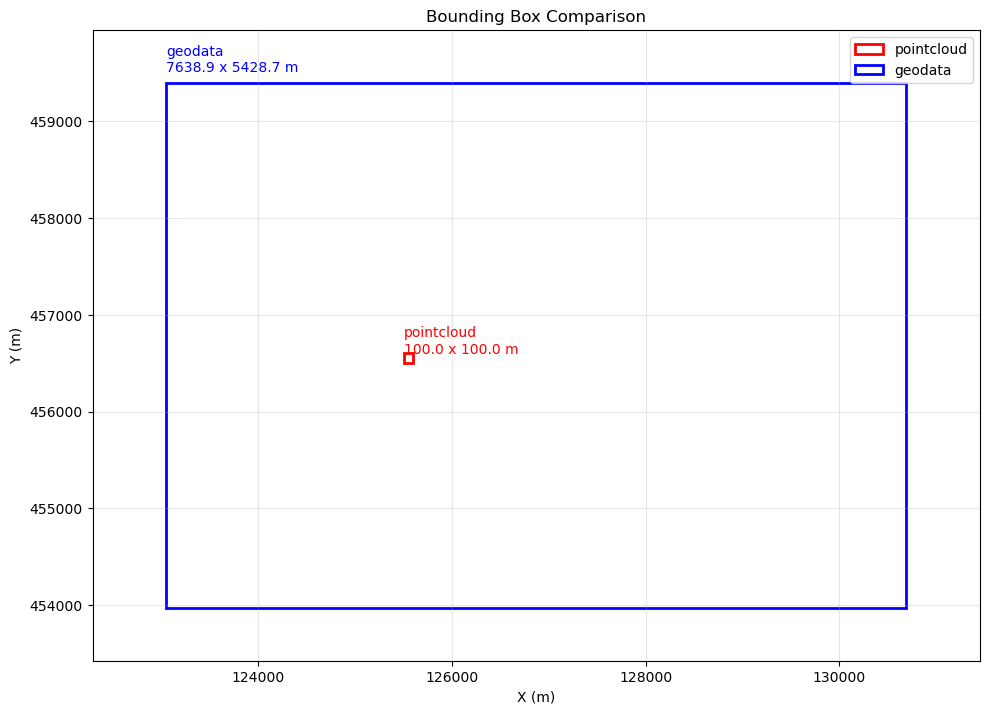

In [67]:
plot_bounding_boxes(
    [pc_bbox.bounds.values.tolist()[0], geo_bbox.bounds.values.tolist()[0]],
    ["pointcloud", "geodata"],
    ["red", "blue"],
    title="Bounding Box Comparison",
)

## Stap 4: Pointcloud classificatie van een pointcloud tile met BGT data

In deze laatste stap geven we de puntenwolk de classificatie van de BGT vlakken waarmee ze overlappen

In [125]:
def load_geodata_with_index(filepath: str) -> gpd.GeoDataFrame:
    """
    Load each layer of the geodata as separate GeoDataFrames.
    Returns a dictionary with layer names as keys and GeoDataFrames as values.
    """

    layers = gpd.list_layers(output_folder / bgt_name).name.to_list()
    geodata = {}
    for layer in layers:
        geodata[layer] = gpd.read_file(filepath, layer=layer)

    return geodata


def prepare_pointcloud_geoms(points: np.ndarray):
    """
    Prepares the pointcloud
    """
    # Extract X,Y coordinates (ignore Z if present)
    xy_points = points[:, :2]

    # Create Point geometries from coordinates
    point_geoms = [Point(x, y) for x, y in xy_points]

    return point_geoms


def points_in_polygons(
    points: np.ndarray,
    point_geoms: list[Point],
    gdf: gpd.GeoDataFrame,
    classification: int = None,
) -> np.ndarray:
    """
    Find which polygon each point falls into.

    Args:
        points: numpy array with shape (n_points, 2) or (n_points, 3) - X,Y coordinates (Z ignored if present)
        gdf: GeoDataFrame with polygon geometries

    Returns:
        numpy array with shape (n_points,) containing the index of the polygon each point falls into.
        Returns -1 if point doesn't fall in any polygon.
    """
    # Create spatial index for fast lookup
    tree = STRtree(gdf.geometry.values)

    # For each point, find which polygon it falls into
    for i, point_geom in enumerate(point_geoms):
        # Query spatial index for potential matches
        possible_matches_idx = list(tree.query(point_geom))

        # Check actual containment for potential matches
        for idx in possible_matches_idx:
            if gdf.geometry.iloc[idx].contains(point_geom):
                if classification is None:
                    points[i, 3] = idx
                else:
                    points[i, 3] = classification
                break  # Found the polygon, move to next point

    return points

In [ ]:
geodata_dict = load_geodata_with_index(output_folder / bgt_name)
print(f"Loaded geodata layers: {list(geodata_dict.keys())}")

Loaded geodata layers: ['begroeidterreindeel', 'onbegroeidterreindeel', 'ondersteunendwaterdeel', 'ondersteunendwegdeel', 'openbareruimte', 'pand', 'vegetatieobject_punt', 'vegetatieobject_vlak', 'waterdeel', 'wegdeel']


In [126]:
lasdata_with_classification = np.zeros((len(lasdata), 4))
lasdata_with_classification[:, :3] = lasdata  # Copy X, Y, Z
lasdata_with_classification[:, 3] = -1

# Prepare shapely point geometries, so we don't do this every time we call the function
lasdata_geoms = prepare_pointcloud_geoms(lasdata_with_classification)

Voordat je het codeblok hieronder draait, open naast je code een CPU monitor, zoals:

1) Windows: task manager --> CPU --> rechter muisklik op de grote grafiek --> logical processors
2) Linux: htop commando

__Vraag: Run nu de code hieronder. Wat zie je in je CPU cores gebeuren?__

In [127]:
# Vind voor elk punt in welk BGT polygoon het valt
for classification, data in enumerate(geodata_dict.values()):
    lasdata_with_classification = points_in_polygons(
        points=lasdata_with_classification,
        point_geoms=lasdata_geoms,
        gdf=data,
        classification=classification + 1,
    )

__Vraag: Kijk nu naar hoe lang deze ene operatie heeft gekost. Hoe lang denk je dat dit zou duren voor alle 100 pointcloud tile?__    
[antwoord]

In [129]:
print(f"Classifications found: {np.unique(lasdata_with_classification[:, 3])}")

Classifications found: [1. 2. 3. 9.]


In [ ]:
las_classified = to_las(
    points=lasdata_with_classification[:, 0:3],
    colors=None,
    extra_dim={"bgt_classification": lasdata_with_classification[:, 3].astype("uint32")},
)

In [ ]:
las_path = output_folder / Path(Path(lasfile_path).stem + "_bgt_classification.las")
las_classified.write(las_path)

## Stap 5: Pointcloud classificatie van alle pointcloud tiles met BGT data

In deze laatste stap gaan we elke tile van de puntenwolk classificeren. Alleen met 1 groot verschil: 
We voeren de classificatie multi-threaded uit!
Python is namelijk standaard single-thread. Dit betekent dat het voor al zijn werk slechts 1 CPU core gebruikt. 
Tegenwoordig hebben laptops echter minimaal 4 cores of meer.
We laten dus 3 cores lekker luieren terwijl eentje keihard werkt!

Wat als we alle cores een aparte taak geven om uit te voeren, zoals het classificeren van een tile? Vervolgens halen we alle classificaties van de cores op en slaan we die op.
Multi-threaded code draaien is in deze workshop de analogie voor cloud computing: In plaats van dat je alles lokaal op 1 machine draait 
(je single-threaded core), 
kunnen we een cluster aan machines aanroepen en elk een stukje van de taak geven (multi-threaded workloads).

In [ ]:
def classifiy_lasfiles(lasfile_path: str, geodata_dict: dict, output_folder: Path) -> None:
    """
    function for multiprocessing.
    """

    lasdata = lasdata_loader(lasfile_path, single_array=True)

    lasdata_with_classification = np.zeros((len(lasdata), 4))
    lasdata_with_classification[:, :3] = lasdata  # Copy X, Y, Z
    lasdata_with_classification[:, 3] = -1

    # Prepare shapely point geometries, so we don't do this every time we call the function
    lasdata_geoms = prepare_pointcloud_geoms(lasdata_with_classification)

    # Vind voor elk punt in welk BGT polygoon het valt
    for classification, data in enumerate(geodata_dict.values()):
        lasdata_with_classification = points_in_polygons(
            points=lasdata_with_classification,
            point_geoms=lasdata_geoms,
            gdf=data,
            classification=classification + 1,
        )

    las_classified = to_las(
        points=lasdata_with_classification[:, 0:3],
        colors=None,
        extra_dim={"bgt_classification": lasdata_with_classification[:, 3].astype("uint32")},
    )

    print(f"Saving output of {str(Path(lasfile_path).stem)} to las file...")
    las_path = output_folder / Path(Path(lasfile_path).stem + "_bgt_classification.las")
    las_classified.write(las_path)

In [132]:
print("Aantal beschikbare cores:", multiprocessing.cpu_count())

Aantal beschikbare cores: 16


In [133]:
# Alle 100 lasfiles verwerken is erg veel. Kies hieronder een subset, of maak je eigen lijst met gekozen lasfiles
# De files worden in dezelfde output folder opgeslagen

lasfiles_subset = lasfiles[0:10]

In [137]:
def classify_single_file(lasfile_path):
    """Wrapper function for pool processing"""
    return classifiy_lasfiles(lasfile_path, geodata_dict, output_folder)


# We use one core less than total to avoid overloading the system
num_cores = min(multiprocessing.cpu_count() - 1, len(lasfiles_subset))
print(f"Using {num_cores} cores to process {len(lasfiles_subset)} files")

with Pool(processes=num_cores) as pool:
    # This will distribute the files across all cores
    pool.map(classify_single_file, lasfiles_subset)

print("All files processed!")

Using 10 cores to process 10 files
Saving output of AHN5_C_125000_456000_2_1 to las file...
Saving output of AHN5_C_125000_456000_5_2 to las file...
Saving output of AHN5_C_125000_456000_8_2 to las file...
Saving output of AHN5_C_125000_456000_9_2 to las file...
Saving output of AHN5_C_125000_456000_1_9 to las file...
Saving output of AHN5_C_125000_456000_3_9 to las file...
Saving output of AHN5_C_125000_456000_0_6 to las file...
Saving output of AHN5_C_125000_456000_6_2 to las file...
Saving output of AHN5_C_125000_456000_4_4 to las file...
Saving output of AHN5_C_125000_456000_5_5 to las file...
All files processed!


__Vraag: Hoe lang heeft het verwerken van de files geduurd? Is dit wat je had verwacht?__    
[antwoord]

__Vraag: Als je kijkt naar de volgorde van files van je subset komt deze niet overeen met de volgorde van de output. Waarom?__
[antwoord]